Заменить используемую сеть на менее "глубокую"

Увеличить размер изображения, задав большее значение чем 256

Изменить соотношение стиля и контента

Сгенерировать стилизованное изображение, используя другие, выбранные вами изображения

Специальные требования:

Ноутбук должен выполняться в Colab или в локальном Jupyter нотбуке. Изображения должны быть приложены (например, вклеены в текутовую ячейку), либо должны быть даны ссылки на них (URL).

Если ноутбук выложен в Colab, не забудьте разрешить к нему доступ. Преподаватель готов подождать получения доступа, но, к сожалению, без доступа, задание будет считаться несданным.

Скрипт можно выполнять в Jupyter на собственном ПК (в том числе на CPU), а можно в Google Colab.

Замечание: Иллюстрации первой части ноутбука могут не открываться в Google Colab. И пока мы не оптимизировали ноутбук для Colab, вы можете прочитать теорию в приложенном HTML файле.

Курс Transfer learning крайне сжатый и выступает ознакомительным для понимания принципов и практик работы с нейросетями. Потому основная цель практики это освоение навыков настройки и изменения параметров уже готового решения. Возьмем код из семинара и настроим параметры исходя из задания.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
device

device(type='cuda')

In [58]:
# Какого размера изображения мы хотим обрабатывать. Изменим его на 512 если обработка будет происходить на видеокарте.

imsize = 512 if torch.cuda.is_available() else 128  # Если нет GPU, делаем изображение поменьше

loader = transforms.Compose([
    transforms.Resize(imsize),  # масштабируем с сохранением соотношения сторон
    transforms.CenterCrop(imsize), # обрежем края чтобы получить квадратное изображение
    transforms.ToTensor()])  # преобразуем в нужный нам класс – Torch Tensor


def image_loader(image_name):
    # Загрузим и преобразуем картинку, вдруг она в оттенках серого или с альфа-каналом...
    image = Image.open(image_name).convert('RGB')
    # нейросеть ждет не просто картинку, а набор картинок
    # поэтому мы добавим к изображению одно мнимое измерение
    # (количество картинок в батче всегда будет равно 1)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("/content/data/sem4.jpg")
content_img = image_loader("/content/data/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "Изображения должны быть одинакового размера, что-то пропущено в процедуре подготовки изображений"

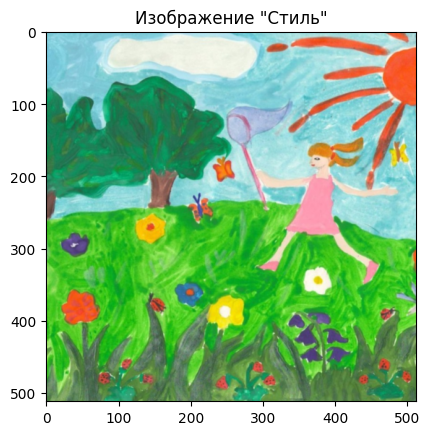

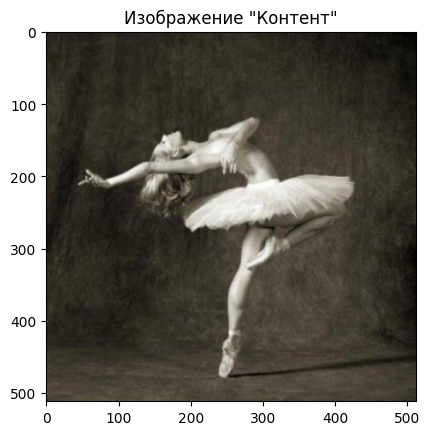

In [59]:
unloader = transforms.ToPILImage()  # Преобразуем в картинку PIL

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # создаем копию тензора чтобы не менять исходный
    image = image.squeeze(0)      # устраняем лишнее измерение (которое делало батч из изображения)
    image = unloader(image)
    plt.imshow(image)

    if title is not None:
        plt.title(title)
    plt.pause(0.001) # Дадим графику обновиться

plt.figure()
imshow(style_img, title='Изображение "Стиль"')

plt.figure()
imshow(content_img, title='Изображение "Контент"')

In [10]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # нуно "отвязать" (detach) набор целевых признаков (target content)
        # от других объектов, которые находят его градиент. Это статический объект
        # Если этого не сделать, метод forward вернут нам ошибку
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


In [11]:
def gram_matrix(input):
    a, b, c, d = input.size()
    # a=размер батча(=1)
    # b=количество карт признаков, для которых мы считаем матрицу
    # (c,d)=размерность карты признаков f (N=c*d)

    features = input.view(a * b, c * d)  # изменим размерность матрицы F_XL, получим \hat F_XL

    G = torch.mm(features, features.t())  # рассчитать произведение матриц чтобы получить матрицу Грама

    # нормализуем значения матрицы Грама, разделив значения матрицы на количество элементов
    return G.div(a * b * c * d)

In [12]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [30]:
# Сохраним исходную модель чтобы сравнить результаты. После закомментируем и перейдем на vgg16

# cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [32]:
# В соответствии с заданием меняем нейросеть на менее глуюлкую vgg16
from torchvision.models import vgg16, VGG16_Weights

cnn = vgg16(weights=VGG16_Weights.DEFAULT).features.eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 134MB/s]


In [60]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# упаковочный класс, чтобы картинку было легче передать в объект ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # преобразуем мат.ожидание и дисперсию при помощи .view так, чтобы
        # их можно было легко умножить на тензор с картинкой
        # Картинка имеет размерность [B x C x H x W]
        # Мы приводим коэффициенты нормализации к размерности [C x 1 x 1]
        # B – размер батча. C – количество каналов. H – высота, W – ширина изображения.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # нормализуем изображение ``img``
        return (img - self.mean) / self.std

In [61]:
# названия слоев, где мы будем рассчитывать расхождение по контенту
content_layers_default = ['conv_4']

# названия слоев, где мы будем рассчитывать расхождение по стилю
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # модуль чтобы нормализоавть изображения
    normalization = Normalization(normalization_mean, normalization_std)

    # будем складывать меры расхождения (лоссы) в удобные массивы
    content_losses = []
    style_losses = []

    # поскольку ``cnn`` является объектом типа ``nn.Sequential``,
    # создадим новый ``nn.Sequential`` куда мы по порядку положим
    # все модули, которые будут проводить вычисления в нейросети
    model = nn.Sequential(normalization)

    i = 0  # пройдемся по элементам в исходной нейросети и дадим им имена
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # Чуть изменим параметры слоев активации (версия которая использована
            # в исходной нейросети не работает с нашей реализацией ``ContentLoss`` и ``StyleLoss``)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        # Добавим очередной модуль в нашу Sequential-модель
        model.add_module(name, layer)

        if name in content_layers:
            # если к последнему слою нужно пристыковать контент-лосс, сделаем это
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # а если имя слоя в списке стиль-лоссов, добавим после него соответствующий лосс
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # все слои которые идут после последнего добавленного контент-лосса или стиль-лосса
    # нам будут не нужны, их можно отбросить
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

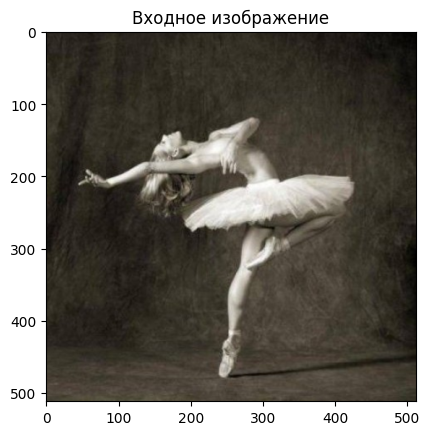

In [62]:
# Чтобы использовать исходную картинку, раскомментируйте:
input_img = content_img.clone()

# Чтобы использовать шум
#input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Входное изображение')

In [46]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [63]:
# Для большей наглядности стиля зададим style_weight=500000, content_weight=10

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=500000, content_weight=10):

    print('Построение модели переноса стиля..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # Укажем, какой объект мы будем оптимизировать (включить параметр requires_grad fields)
    input_img.requires_grad_(True)
    # Переключим модель в режим исполнения, чтобы заморозить слои вроде dropout или батч нормализации normalization layers
    model.eval()
    # Очевидно, мы не будем оптимизировать модель, так что заморозим все параметры
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Оптимизируем картинку..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # скорректируем значения входного изображения
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad() # обнуляем градиенты (иногда их используют между итерациями, но не сейчас)
            model(input_img) # знакомая вам функция, отправить картинку в модель

            # Посчитаем расхождение изображений по стилю и содержимому
            style_score = 0
            content_score = 0

            for sl in style_losses: style_score += sl.loss
            for cl in content_losses: content_score += cl.loss

            style_score *= style_weight # Домножаем каждую компоненту лосса на заданный вес
            content_score *= content_weight

            loss = style_score + content_score
            # И по этому значению осуществляем обратное распространение ошибки (обратно по сети, вплоть до изображения)
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # и в последний раз вернем изображение в диапазон
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Построение модели переноса стиля..
Оптимизируем картинку..
run [50]:
Style Loss : 53.700466 Content Loss: 88.860077

run [100]:
Style Loss : 26.027420 Content Loss: 81.354721

run [150]:
Style Loss : 15.487481 Content Loss: 79.136208

run [200]:
Style Loss : 11.595899 Content Loss: 78.035355

run [250]:
Style Loss : 10.777719 Content Loss: 76.799515

run [300]:
Style Loss : 10.581061 Content Loss: 76.390717



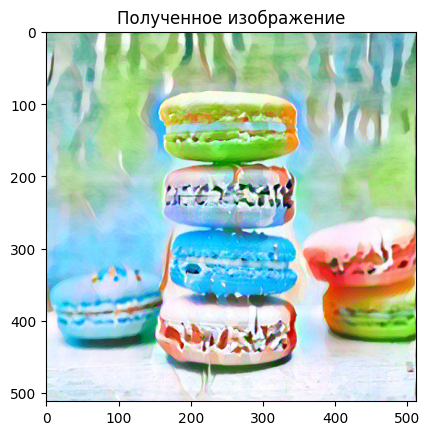

In [21]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Полученное изображение')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

Продублируем часть финальную часть кода чтобы сохранить полученные результаты генерации изображений. Полученные тензоры преобразуем в картинки и сохраним.

In [27]:
torch.save(output, '/content/result/image.jpg')

Построение модели переноса стиля..
Оптимизируем картинку..


/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


run [50]:
Style Loss : 155.929504 Content Loss: 156.341385

run [100]:
Style Loss : 54.020260 Content Loss: 122.783676

run [150]:
Style Loss : 32.851566 Content Loss: 107.600693

run [200]:
Style Loss : 21.826134 Content Loss: 101.022484

run [250]:
Style Loss : 15.151460 Content Loss: 97.680923

run [300]:
Style Loss : 13.313695 Content Loss: 94.800171



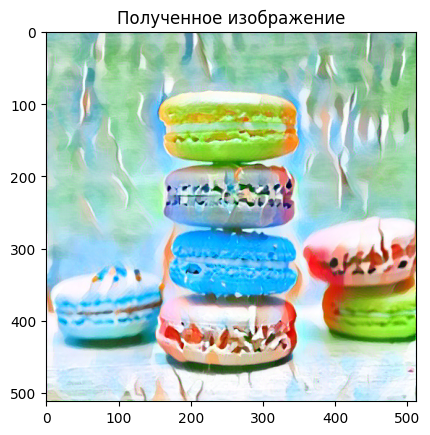

In [39]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Полученное изображение')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [40]:
torch.save(output, '/content/result/imagevgg16.jpg')

Мы получили пректически то же изображение. ПОпробуем изменить стиль обучающего изображения.

Построение модели переноса стиля..
Оптимизируем картинку..
run [50]:
Style Loss : 730.391846 Content Loss: 412.596863

run [100]:
Style Loss : 252.815918 Content Loss: 397.356110

run [150]:
Style Loss : 305.408630 Content Loss: 377.826813

run [200]:
Style Loss : 151.686371 Content Loss: 389.071045

run [250]:
Style Loss : 71.942078 Content Loss: 389.863251

run [300]:
Style Loss : 12156.239258 Content Loss: 456.813202



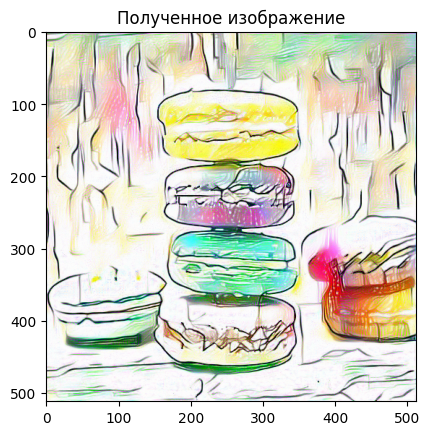

In [48]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Полученное изображение')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [49]:
torch.save(output, '/content/result/image2_vgg16.jpg')

Мы получили кардинально другой результат. Проведем третий тест с новым изображением.

Построение модели переноса стиля..
Оптимизируем картинку..
run [50]:
Style Loss : 131.723099 Content Loss: 69.018257

run [100]:
Style Loss : 51.623474 Content Loss: 53.822128

run [150]:
Style Loss : 34.223671 Content Loss: 56.921539

run [200]:
Style Loss : 18.439905 Content Loss: 59.809669

run [250]:
Style Loss : 13.384609 Content Loss: 54.304268

run [300]:
Style Loss : 12.827213 Content Loss: 49.636093



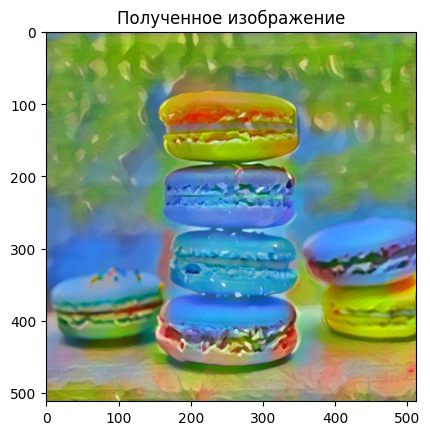

In [56]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Полученное изображение')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [57]:
torch.save(output, '/content/result/image3_vgg16.jpg')

Определенно подход работает. Сделаем преобразование для нового изображения.

Построение модели переноса стиля..
Оптимизируем картинку..


/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


run [50]:
Style Loss : 295.908356 Content Loss: 167.872589

run [100]:
Style Loss : 97.668098 Content Loss: 157.460617

run [150]:
Style Loss : 42.092178 Content Loss: 145.477585

run [200]:
Style Loss : 31.259220 Content Loss: 137.648834

run [250]:
Style Loss : 24.891174 Content Loss: 133.945679

run [300]:
Style Loss : 20.821066 Content Loss: 132.524628



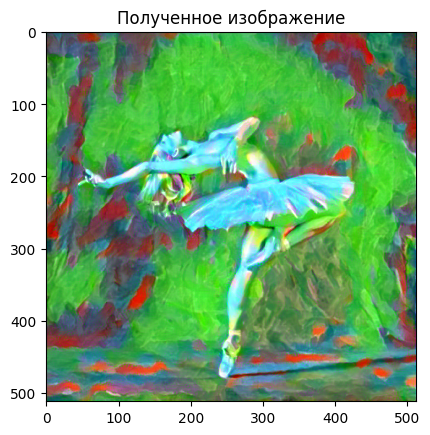

In [64]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Полученное изображение')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [65]:
torch.save(output, '/content/result/image4_vgg16_test2.jpg')

Даже без понимания архитектуры нейросети мы смогли использловать результаты ее работы в нужных нам целях. Однако для достижения лучших результатов необходимо более глубокое изучение этого инструментария.